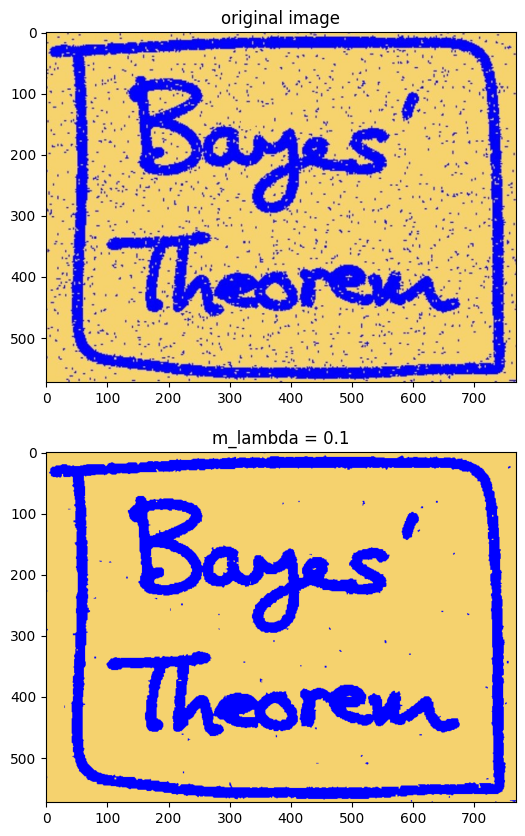

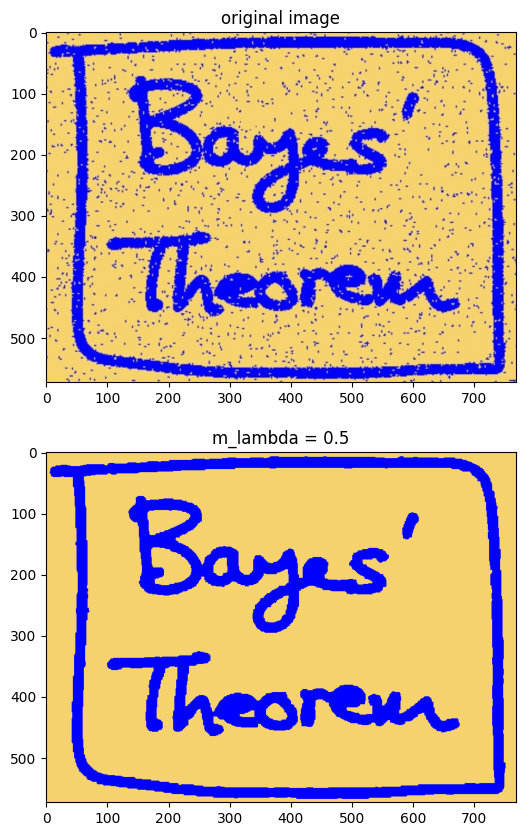

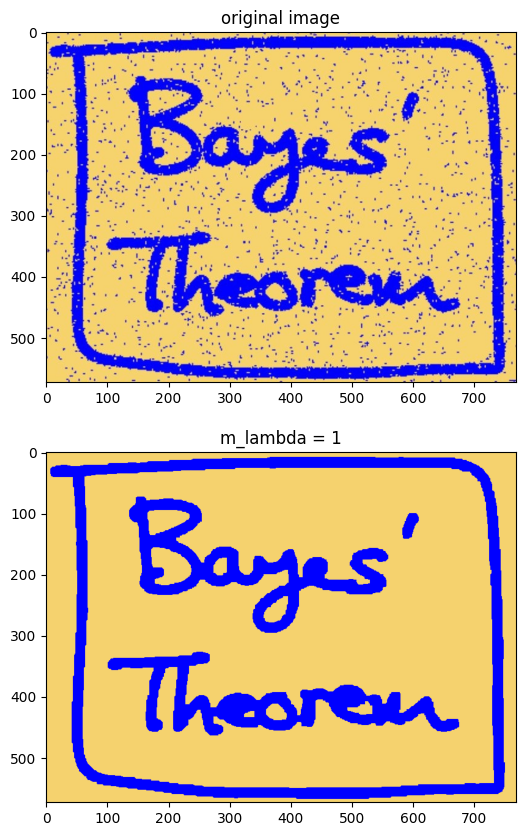

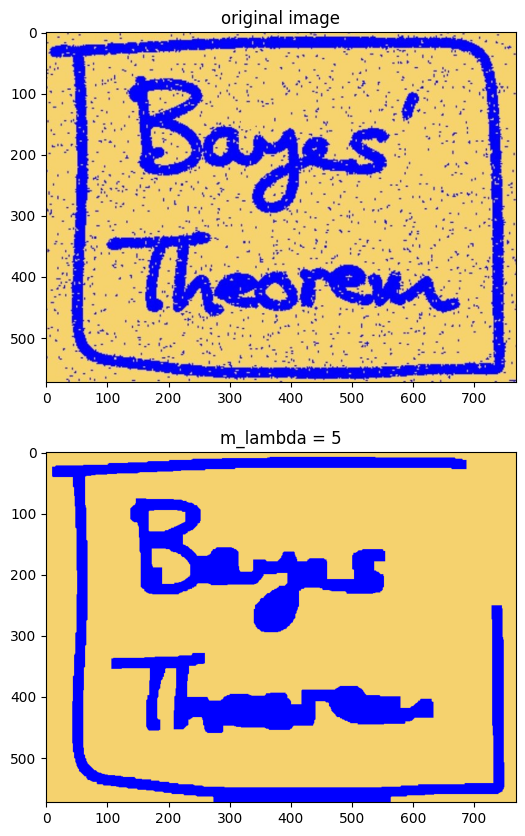

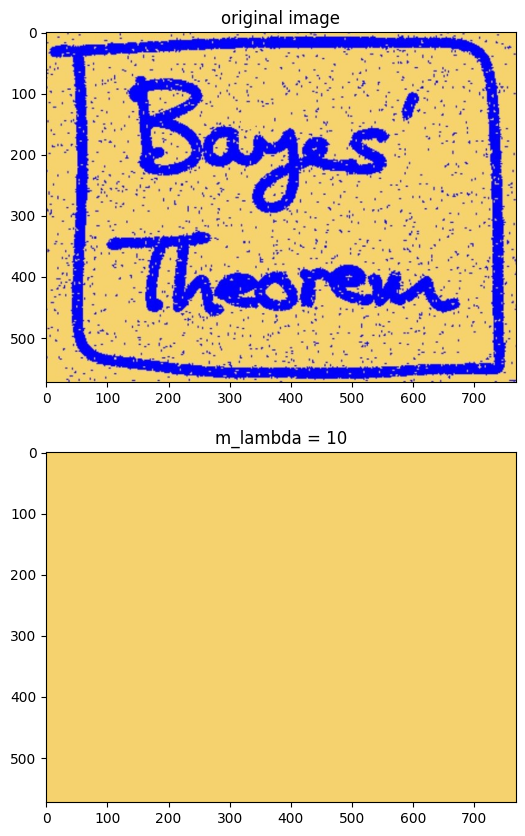

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from gco import pygco

def calculate_color_distance(a, b):
    # 计算两个RGB颜色之间的绝对颜色距离 # Calculate the absolute color distance between two RGB colors
    return np.mean(np.abs(a - b))

def segment_and_denoise_image(input_path, src_color, sink_color, my_lambda=1):
    # 读取输入图像 # Read the input image
    srcImg = cv2.imread(input_path)
    denoiseImg = np.copy(srcImg)
    
    # 将图像转换为RGB颜色空间 # Convert image to RGB color space
    srcImg = cv2.cvtColor(srcImg, cv2.COLOR_BGR2RGB)
    denoiseImg = cv2.cvtColor(denoiseImg, cv2.COLOR_BGR2RGB)
    
    # 获取图像的高度和宽度 # Get the height and width of the image
    Height, Width, _ = srcImg.shape

    # 创建一元概率数组 #Create a univariate probability array
    UnivariateProbabilityArray = np.zeros((Height, Width, 2))
    
    # 创建成对势能矩阵 #Create a pairwise potential energy matrix
    PairwisePotentialEnergyMatrix = (1 - np.eye(2))

    for x in range(Height):
        for y in range(Width):
            PixelAtxy = srcImg[x][y]
            # 计算前景和背景标签 # Calculate foreground and background labels
            src_label = calculate_color_distance(PixelAtxy, src_color) / 255
            sink_label = calculate_color_distance(PixelAtxy, sink_color) / 255
            UnivariateProbabilityArray[x][y] = [src_label, sink_label]

    # 执行图像分割优化 #Perform image segmentation optimization
    labels = pygco.cut_grid_graph_simple(UnivariateProbabilityArray, PairwisePotentialEnergyMatrix * my_lambda, n_iter=-1)
    labels = labels.reshape(Height, Width)

    for x in range(Height):
        for y in range(Width):
            if labels[x][y] == 1:
                denoiseImg[x][y] = sink_color
            if labels[x][y] == 0:
                denoiseImg[x][y] = src_color

    return srcImg, denoiseImg

if __name__ == '__main__':
    # 定义前景和背景颜色 # Define foreground and background colors
    src_color = np.array([0, 0, 255])  # 蓝色 = 前景 blue = foreground
    sink_color = np.array([245, 210, 110])  # 黄色 = 背景 yellow = background

    # 指定图像路径 #Specify image path
    input_path = 'bayes_in.jpg'

    lambda_values = [0.1, 0.5, 1, 5, 10]

    for loop_lambda in lambda_values:
        # 执行图像分割和去噪 #Perform image segmentation and denoising
        original_image, denoised_image = segment_and_denoise_image(input_path, src_color, sink_color, loop_lambda)
        
        # 显示原始图像和去噪后的图像 # Display the original image and the denoised image
        plt.figure(figsize=(10, 10))
        plt.subplot(211)
        plt.title('original image')
        plt.imshow(original_image)
        plt.subplot(212)
        plt.title(f'lambda = {loop_lambda}')
        plt.imshow(denoised_image)
        plt.show()

In the above experiments, λ = 0.1 and λ = 0.5 have the best results. When λ = 0.1, the details of the letter e are preserved, but the noise cannot be completely removed. λ = 0.5 completely removes the noise and the original image is not seriously distorted.

When λ=5 or λ=10, the function overemphasizes the influence of surrounding information, resulting in greater image distortion.